# Bond lattice mean-field model for a Morse potential - NPT

In [1]:
from pyiron_atomistics import Project

from scipy.interpolate import UnivariateSpline, CubicSpline
from scipy.optimize import root_scalar, root
from scipy.integrate import cumtrapz

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import gridspec

from scipy.constants import physical_constants
KB = physical_constants['Boltzmann constant in eV/K'][0]

from pyiron_contrib.atomistics.mean_field.core.bond_analysis import StaticBondAnalysis, MDBondAnalysis

import seaborn as sns
sns.set_context('paper', font_scale=1.5, rc={"lines.linewidth": 2})

/cmmc/u/system/SLES12/soft/pyiron/dev/anaconda3/lib/python3.8/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: NOT-A-GIT-REPOSITORY is an invalid version and will not be supported in a future release
  warnings.warn(


In [2]:
alpha = 1.5
pr = Project('morse_al/mfm')
pr_md_npt = Project('morse_al/md_runs_npt/alpha_' + str(alpha).replace('.', '_'))

In [3]:
# potential functions
D = 0.1
a_0 = 2.856
kappa = 0.

# for lammps
def md_morse(D=D, alpha=alpha, r_0=a_0, b=1):
    config = 'atom_style bond\nbond_style morse\n'
    for i in range(b):
        vals = (i+1, D, alpha, a_0)
        config += 'bond_coeff %d %.7f %.7f %.7f\n'%(vals)
    return pd.DataFrame({'Name': ['Morse'],
                         'Filename': [[]],                             
                         'Model'   : ['Morse'], 
                         'Species' : [['Al']], 
                         'Config'  : [[config]]})

# longitudinal_potential
def morse(r, D=D, alpha=alpha, a_0=a_0):
    return D*(1.0+np.exp(-2.0*alpha*(r-a_0)) - 2.0*np.exp(-alpha*(r-a_0)))

def dmorse(r, D=D, alpha=alpha, a_0=a_0):
    return -2.0*alpha*D*(np.exp(-2.0*alpha*(r-a_0)) - np.exp(-alpha*(r-a_0)))

# harmonic potential
def harm(r, kappa=kappa):
    return D*alpha*alpha*kappa*(r**2)

In [4]:
# structure
element = 'Al'
potential = md_morse()
supercell = 4
n_atoms = 4*supercell**3
temperatures = np.linspace(100, 700, 7)
pressure = 0.0001  # in GPa
samples = 5

In [5]:
# minimize structure
zero = pr.create.job.Lammps('zero', delete_existing_job=True)
zero.structure = pr.create.structure.bulk(element, cubic=True).repeat(supercell)
zero.potential = potential
zero.calc_minimize(pressure=pressure)
zero.run()
structure = zero.get_structure()
a_0 = (structure.cell/supercell/np.sqrt(2))[0][0]
U_0 = zero.output.energy_pot[-1]/n_atoms

The job zero was saved and received the ID: 18414826


In [6]:
# analyze bonds and get rotations and displacement matrix
stat_ba = pr.create_job(StaticBondAnalysis, 'stat_ba', delete_existing_job=True)
stat_ba.input.structure = structure.copy()
stat_ba.input.n_shells = 1
stat_ba.run()

The job stat_ba was saved and received the ID: 18414827


In [7]:
# normalized displacement vectors along which to displace our atom
disp_matrix = np.array(stat_ba.output.per_shell_transformation_matrices[0][0])
# these are also the normalized long, t1 and t2 vectors
long_hat, t1_hat, t2_hat = disp_matrix
# rotations
rotations = stat_ba.output.per_shell_0K_rotations[0]
# a_xyz
a_xyz = long_hat*a_0

In [8]:
# load the nvt jobs from the md runs
md_jobs_npt = []
for i in range(len(temperatures)):
    temp_jobs = []
    for j in range(samples):
        temp_jobs.append(pr_md_npt.load('nve_temp_' + str(i) + '_sample_' + str(j)))
    md_jobs_npt.append(temp_jobs)

In [9]:
# extract mean anharmonic internal energy from the md run
def get_md_ah_U(temp_jobs, temperature, snapshots=200):
    ah_U_pa = []
    for job in temp_jobs:
        if job.status == 'finished':
            U_pa = np.mean(job['output/generic/energy_pot'][snapshots:])/n_atoms - U_0
            T_virial = np.mean(job['output/generic/temperature'][snapshots:])
            ah_U_pa.append(U_pa - 1.5*KB*T_virial)
    return np.mean(ah_U_pa)*1000, np.std(ah_U_pa)/np.sqrt(len(temp_jobs))*1000  # in meV

U_md_npt = []
U_md_npt_err = []
for (temp_jobs, temp) in zip(md_jobs_npt, temperatures):
    ah_U_pa, ah_U_pa_err = get_md_ah_U(temp_jobs, temp)
    U_md_npt.append(ah_U_pa)
    U_md_npt_err.append(ah_U_pa_err)
U_md_npt = np.array(U_md_npt)
U_md_npt_err = np.array(U_md_npt_err)

In [10]:
# analyze MD bonds for the highest temperature
md_ba_jobs = []
for (temp, temp_jobs) in zip(temperatures, md_jobs_npt):
    md_job = temp_jobs[0]
    md_ba = pr.create_job(MDBondAnalysis, 'md_ba_npt_' + str(temp).replace('.','_'), delete_existing_job=True)
    md_ba.input.structure = structure.copy()
    md_ba.input.n_shells = 1
    md_ba.input.md_job = md_job.copy()
    md_ba.input.thermalize_snapshots = 200
    md_ba.run()
    md_ba_jobs.append(md_ba)

The job md_ba_npt_100_0 was saved and received the ID: 18414828
The job md_ba_npt_200_0 was saved and received the ID: 18414829
The job md_ba_npt_300_0 was saved and received the ID: 18414830
The job md_ba_npt_400_0 was saved and received the ID: 18414831
The job md_ba_npt_500_0 was saved and received the ID: 18414832
The job md_ba_npt_600_0 was saved and received the ID: 18414833
The job md_ba_npt_700_0 was saved and received the ID: 18414834


In [11]:
# bond arrangement functions

# for 1d
def get_b_array(long_samples, t1_samples, t2_samples):
    b_array = np.outer(long_samples, long_hat) + np.outer(t1_samples, t1_hat) +  np.outer(t2_samples, t2_hat)
    return b_array

# for 3d
def get_sample_mesh(long_samples, t1_samples, t2_samples):
    long_mesh, t1_mesh, t2_mesh = np.meshgrid(long_samples, t1_samples, t2_samples, indexing='ij')
    return long_mesh, t1_mesh, t2_mesh

def get_b_grid(long_mesh, t1_mesh, t2_mesh):
    b_grid = np.tensordot(long_mesh, long_hat, axes=0) + np.tensordot(t1_mesh, t1_hat, axes=0) + \
             np.tensordot(t2_mesh, t2_hat, axes=0)
    return b_grid

In [12]:
# create bond vectors from the MD bond distribution (so a seperate one for each temperature)
n_bins = 51
long_meshs, t1_meshs, t2_meshs = [], [], []
for c in range(len(temperatures)):
    md_rho, md_bins = md_ba_jobs[c].get_3d_histogram_long_t1_t2(n_bins=n_bins, shell=0)
    long_meshs.append(md_bins[0])
    t1_meshs.append(md_bins[1])
    t2_meshs.append(md_bins[2])
    
# since our rotations are done in the xyz coordinate system, we convert them to xyz
b_grids = []
for c in range(len(temperatures)):
    b_grids.append(get_b_grid(long_meshs[c], t1_meshs[c], t2_meshs[c]))

In [13]:
# # create custom meshs
# n_bins = 51
# long_samples = np.linspace(1.8, 4.5, n_bins)
# t1_samples = np.linspace(-1.5, 1.5, n_bins)
# t2_samples = t1_samples.copy()
# long_mesh, t1_mesh, t2_mesh = get_sample_mesh(long_samples, t1_samples, t2_samples)
# b_grids = [get_b_grid(long_mesh, t1_mesh, t2_mesh)]*len(temperatures)

In [14]:
# single bonding potential
def V_1(b_xyz):
    r = np.linalg.norm(b_xyz, axis=-1)
    return morse(r)

# single bonding potential gradient
def dV_1(b_xyz):
    V = V_1(b_xyz=b_xyz)
    long_samples = np.dot(b_xyz, long_hat)[:, 0, 0]
    t1_samples = np.dot(b_xyz, t1_hat)[0, :, 0]
    t2_samples = np.dot(b_xyz, t2_hat)[0, 0, :]
    return np.gradient(V, long_samples, t1_samples, t2_samples, edge_order=2)

# each mean field component
def V_mf_component(b_xyz, rotation, a_s=1., a_ex=1.):
    """
    here, a_s=the 'global' strain and a_ex=the 'pseudo' strain, which is equal to the 'global' strain at P=0 for 
    a given temperature. Once a_ex is established for a temperature, it remains the same for that temperature for 
    all new 'global' strains that we would like our model to predict free energies for.
    """
    return V_1((b_xyz-a_xyz*a_s*a_ex)@rotation.T+a_xyz*a_s*a_ex)

# mean field potential
def V_mf(b_xyz, a_s=1., a_ex=1.):
    vmf = V_1(b_xyz)/2
    for rot in rotations[1:]:
        vmf += V_mf_component(b_xyz=b_xyz, rotation=rot, a_s=a_s, a_ex=a_ex)/2
    return vmf

# mean field correlated potential
def V_mfc(b_xyz, a_s=1., a_ex=1.):
    vmfc = V_mf_component(b_xyz=b_xyz, rotation=rotations[0], a_s=a_s, a_ex=a_ex)
    for i, rot in enumerate(rotations):
        if i not in [0, 1]:
            vmfc += V_mf_component(b_xyz=b_xyz, rotation=rot, a_s=a_s, a_ex=a_ex)/2
    return vmfc

# # linear correction function 1-d
# def find_linear_correction(temperature=100., a_s=1., a_ex=1., nstep=10000, minr=0.1, maxr=5.):
#     r = np.linspace(minr, maxr, nstep, endpoint=True)
#     r_array = get_b_array(r, np.zeros(nstep), np.zeros(nstep))
#     V = V_mfc(b_xyz=r_array, a_s=a_s, a_ex=a_ex)
#     V -= V.min()
#     sel = V/temperature/KB<200.0 
#     r, V = r[sel], V[sel]
#     aa = a_s*a_0
#     def f(m):
#         rho = brho * np.exp(-m*(r-aa)/temperature/KB)
#         res = np.abs(np.log((rho*r).sum()/rho.sum()/aa)).sum()
#         return res
#     brho = np.exp(-(V-V.min())/temperature/KB)
#     solver = root_scalar(f, x0=0.0, x1=0.01, rtol=1e-8)
#     return solver.root

# linear correction function
def find_linear_correction(b_xyz, temperature=100., a_s=1., a_ex=1.):
    """
    since the 1-d linear correction was not correctly setting <b>=a (bug in the code?) I use the 3d bond vectors
    to find the linear correction. This works.
    """
    V = V_mfc(b_xyz=b_xyz, a_s=a_s, a_ex=a_ex)
    V -= V.min()
    long_mesh = np.dot(b_xyz, long_hat)
    sel = V/temperature/KB<200.0 
    long_mesh, V = long_mesh[sel], V[sel]
    aa = a_s*a_0
    def f(m):
        rho = brho*np.exp(-m*(long_mesh-aa)/temperature/KB)
        res = np.abs(np.log((rho*long_mesh).sum()/rho.sum()/aa)).sum()
        return res
    brho = np.exp(-(V-V.min())/temperature/KB)
    solver = root_scalar(f, x0=0.0, x1=0.01, rtol=1e-8)
    return solver.root

# mean field correlated potential with linear correction term
def V_mfc_lc(b_xyz, temperature=100., a_s=1., a_ex=1.):
    lm = find_linear_correction(b_xyz=b_xyz, temperature=temperature, a_s=a_s, a_ex=a_ex)
    # NOTE here that the additional local strain is NOT considered here, as this will make the model predict
    # the correction term at that strain, thus violating <b>=a.
    lc = lm*(np.dot(b_xyz, long_hat)-a_0*a_s)
    vmfclc = V_mfc(b_xyz=b_xyz, a_s=a_s, a_ex=a_ex)+lc
    return vmfclc

# helper method to find virial quantities
def virial_helper(b_xyz, a_s=1., a_ex=1., pressure=False):
    dV = np.array(dV_1(b_xyz))
    if not pressure:
        db_dV = (np.dot(b_xyz, long_hat)-a_0*a_s)*dV[0] + np.dot(b_xyz, t1_hat)*dV[1] + np.dot(b_xyz, t2_hat)*dV[2]
    else:
        db_dV = a_0*a_s*dV[0] # + np.dot(b_xyz, t1_hat)*dV[1] + np.dot(b_xyz, t2_hat)*dV[2]
    return db_dV

# bonding density function
def get_rho(v, temperature=100.):
    rho = np.exp(-(v-v.min())/KB/ temperature)
    return rho/rho.sum()

# virial temperature
def find_virial_T(b_xyz, temperature=100., a_s=1., a_ex=1.):
    db_dV = virial_helper(b_xyz, a_s=a_s, a_ex=a_ex)
    vmfclc = V_mfc_lc(b_xyz=b_xyz, temperature=temperature, a_s=a_s, a_ex=a_ex)
    rho = get_rho(v=vmfclc, temperature=temperature)
    return 2./KB*(rho*db_dV).sum()

# virial pressure
def find_virial_P(b_xyz, temperature=100., a_s=1., a_ex=1.):
    db_dV = virial_helper(b_xyz, a_s=a_s, a_ex=a_ex, pressure=True)
    vmfclc = V_mfc_lc(b_xyz=b_xyz, temperature=temperature, a_s=a_s, a_ex=a_ex)
    rho = get_rho(v=vmfclc, temperature=temperature)
    N_by_V = n_atoms/((a_0*a_s*np.sqrt(2)*supercell)**3)
    return N_by_V*(KB*temperature+4.*((rho*db_dV).sum()))

# 2 virials, 1 method
def find_virial(b_xyz, temperature=100., a_s=1., a_ex=1.):
    """
    Find both the virial temperature and pressure in the same method.
    """
    vmfclc = V_mfc_lc(b_xyz=b_xyz, temperature=temperature, a_s=a_s, a_ex=a_ex)
    rho = get_rho(v=vmfclc, temperature=temperature)
    db_dV_T = virial_helper(b_xyz=b_xyz, a_s=a_s, a_ex=a_ex)
    virial_T = 2./KB*(rho*db_dV_T).sum()
    db_dV_P = virial_helper(b_xyz, a_s=a_s, a_ex=a_ex, pressure=True)
    N_by_V = n_atoms/((a_0*a_s*np.sqrt(2)*supercell)**3)
    virial_P = N_by_V*(KB*temperature+4.*((rho*db_dV_P).sum()))
    return virial_T, virial_P

# effective temperature
def find_eff_T(b_xyz, temperature=100., a_s=1., a_ex=1.):
    print("Initial temperature: {}".format(temperature))
    def dvirialE(eff_temperature):
        res = find_virial_T(b_xyz=b_xyz, temperature=eff_temperature, a_s=a_s, a_ex=a_ex)
        return res/(temperature+1e-20)-1.
    solver = root_scalar(dvirialE, x0=temperature, x1=temperature+10, rtol=1e-8)
    print("Effective temperature: {}".format(solver.root))
    return solver.root
    
# effective temperature + strain
def find_eff_strain_and_T(b_xyz, temperature=100., pressure=1e-10, a_s=1., a_ex=1.):
    """
    Optimize both the effective temperature and strain corresponding to a given pressure. Presently, I use this
    method to set my pressure to 0 to obtain a_ex.
    """
    def dvirialPT(arg):
        res_T, res_P = find_virial(b_xyz=b_xyz, temperature=arg[0], a_s=arg[1], a_ex=arg[1])
        return [res_T/(temperature+1e-20)-1., res_P/(pressure+1e-20)-1.]
    solver = root(dvirialPT, x0=(temperature, a_s), tol=1e-8)
    print('Effective temperature: {}\nGlobal strain: {}'.format(solver.x[0], solver.x[1]))
    return solver.x

# strain_at_pressure
def find_strain_at_pressure(b_xyz, temperature=100., pressure=1e-20, a_ex=1., a_s=1.):
    """
    seperate method to find the strain at an input pressure.
    """
    def f(a_s):
        res = find_virial_P(b_xyz=b_xyz, temperature=temperature, a_s=a_s, a_ex=a_ex)
        return res/(pressure+1e-20)-1.
    solver = root_scalar(f, x0=a_ex*0.99, x1=a_ex*1.01, rtol=1e-8)
    return solver.root

# get ah U's using this function...
def get_ah_U(rhos, temperatures=temperatures):
    return np.array([(6*(((V_1(b_grids[i]) - V_1(a_xyz))*rho).sum()) - 1.5*KB*t)*1000 
                           for i, (rho, t) in enumerate(zip(rhos, temperatures))])

# get ah F's using this function...
def get_ah_F(ah_Us, temperatures=temperatures, n_fine=10000):
    fine_temperatures = np.linspace(temperatures[0], temperatures[-1], n_fine, endpoint=True)
    ah_U_eqn = UnivariateSpline(x=temperatures, y=ah_Us, k=3, s=0)
    return -cumtrapz(ah_U_eqn(fine_temperatures), 1/fine_temperatures)*fine_temperatures[1:], fine_temperatures[1:]

In [15]:
# collect effective temperatures and pseudo strains for each temperature using the new approach
eff_parameters = np.array([find_eff_strain_and_T(b_xyz, t, pressure) for b_xyz, t in zip(b_grids, temperatures)]).T
eff_temperatures_new, pseudo_strains = eff_parameters

Effective temperature: 99.79150421106391
Global strain: 1.0062102234640375
Effective temperature: 198.94728796409652
Global strain: 1.0128133122669747
Effective temperature: 297.1438676690236
Global strain: 1.019980475171334
Effective temperature: 393.255183143703
Global strain: 1.0279369695867742
Effective temperature: 486.51875395186016
Global strain: 1.0368166845435047
Effective temperature: 574.8254791620155
Global strain: 1.0472475401673842
Effective temperature: 654.1924151591791
Global strain: 1.060014706701452


In [16]:
# collect global strains for the given pressure using the pseudo strains and effective temperatures
global_strains = np.array([find_strain_at_pressure(b_grid, temp, pressure, a_ex) 
                           for temp, b_grid, a_ex in zip(eff_temperatures_new, b_grids, pseudo_strains)])

In [17]:
# ah_Us and ah_Fs

# fixed pressure = global strain and pseudo strain
vmfcv_ps = []
mfcv_ps_rhos = []
for i, (eff_temp, s, ex) in enumerate(zip(eff_temperatures_new, global_strains, pseudo_strains)):
    v = V_mfc_lc(b_grids[i], a_s=s, a_ex=ex, temperature=eff_temp)
    vmfcv_ps.append(v)
    mfcv_ps_rhos.append(get_rho(v, eff_temp))
U_mfcv_ps = get_ah_U(mfcv_ps_rhos, temperatures=temperatures)
F_mfcv_ps, fine_temperatures = get_ah_F(U_mfcv_ps, temperatures=temperatures)

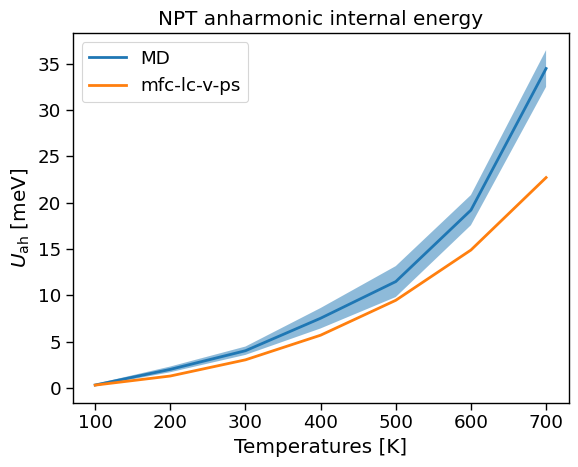

In [18]:
plt.title('NPT anharmonic internal energy')
plt.xlabel('Temperatures [K]')
plt.ylabel('$U_{\mathrm{ah}}$ [meV]')
plt.plot(temperatures, U_md_npt, label='MD')
plt.fill_between(temperatures, U_md_npt-U_md_npt_err, U_md_npt+U_md_npt_err, alpha=0.5)
plt.plot(temperatures, U_mfcv_ps, label='mfc-lc-v-ps')
plt.legend()
plt.show()

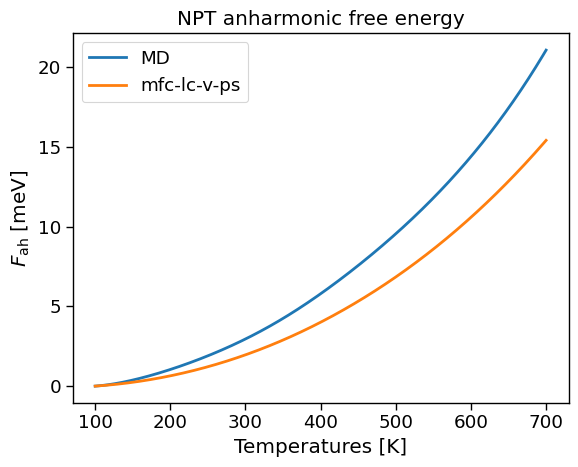

In [19]:
F_md_nvt, fine_temperatures = get_ah_F(U_md_npt, temperatures=temperatures)
plt.title('NPT anharmonic free energy')
plt.xlabel('Temperatures [K]')
plt.ylabel('$F_{\mathrm{ah}}$ [meV]')
plt.plot(fine_temperatures, F_md_nvt, label='MD')
plt.plot(fine_temperatures, F_mfcv_ps, label='mfc-lc-v-ps')
plt.legend()
plt.show()

In [20]:
# load npt runs to get npt volume
md_jobs = []
for i in range(len(temperatures)):
    temp_jobs = []
    for j in range(samples):
        temp_jobs.append(pr_md_npt.inspect('npt_temp_' + str(i) + '_sample_' + str(j)))
    md_jobs.append(temp_jobs)

In [21]:
volumes = np.array([np.mean([md_jobs[i][j]['output/generic/volume'][200:] for j in range(samples)])
                    for i, _ in enumerate(temperatures)])
lattice_a = np.cbrt(volumes)/4

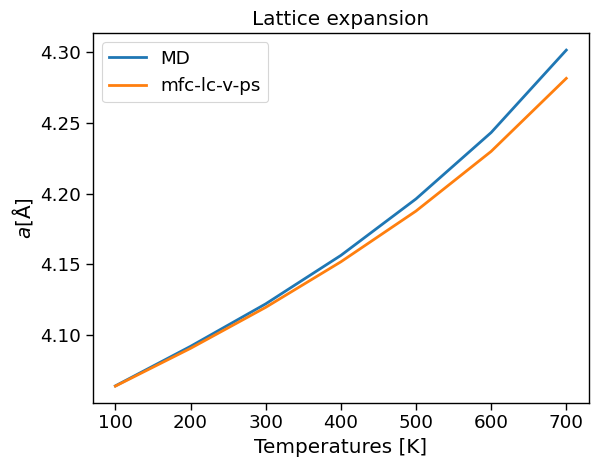

In [22]:
plt.title('Lattice expansion')
plt.xlabel('Temperatures [K]')
plt.ylabel('$a [\mathrm{\AA}]$')
plt.plot(temperatures, lattice_a, label='MD')
plt.plot(temperatures, global_strains*a_0*np.sqrt(2), label='mfc-lc-v-ps')
plt.legend()
plt.show()